# Imports

In [1]:
import pandas as pd
import random
%matplotlib inline

# Inputs

In [2]:
stock_a_weight = 0.6
stock_a_mean_ret = 0.1
stock_a_stdev = 0.3
stock_b_mean_ret = 0.05
stock_b_stdev = 0.1
n_periods = 100
base_price = 100

## Simulating Returns

We can use the `random.normalvariate` function to draw returns from a normal distribution. We just need to pass the mean and standard deviation. Run the next cell a few times and see it change. 

In [3]:
random.normalvariate(stock_a_mean_ret, stock_a_stdev)

-0.06003751712973657

But we don't want a single return, we want 100 periods of returns. A list comprehension works great for this purpose.

In [4]:
stock_a_rets = [random.normalvariate(stock_a_mean_ret, stock_a_stdev) for i in range(n_periods)]

In [5]:
stock_a_rets[:10]

[-0.05007245571504243,
 -0.1454978243271238,
 0.044559013505450974,
 -0.07119197975120972,
 -0.010807524431576121,
 0.35792965781788866,
 0.28728912590512223,
 0.07523506146025115,
 -0.22778047741543458,
 -0.3755467011699237]

In [6]:
len(stock_a_rets)

100

Let's wrap this in a function so we can reuse it for both stocks.

In [7]:
def returns_for_stock(mean, stdev, n_periods):
    stock_rets = [random.normalvariate(mean, stdev) for i in range(n_periods)]
    return stock_rets

returns_for_stock(stock_a_mean_ret, stock_a_stdev, n_periods)[:10]

[-0.06904483096064337,
 -0.2607373489474416,
 -0.05331123262076276,
 0.19499456485140926,
 -0.36847402863369405,
 -0.1834856048157936,
 -0.05215238492508878,
 0.2618769675695804,
 0.4171428841957724,
 0.17065919195697724]

## Calculating Prices

There are a number of different ways to get the prices over time from the returns. We could loop through the returns, taking the prior price and multiplying it by 1 + the current return, and appending the price to a list. But I will show an approach in Pandas that uses cumulative gross returns.

First create the `DataFrame` and add returns data.

In [8]:
df = pd.DataFrame()
df['Stock A Return'] = returns_for_stock(stock_a_mean_ret, stock_a_stdev, n_periods)
df['Stock B Return'] = returns_for_stock(stock_b_mean_ret, stock_b_stdev, n_periods)
df.head()  # displays the first few rows

,Stock A Return,Stock B Return
0,0.301510,-0.147742
1,0.405175,-0.080882
2,-0.142255,0.013351
3,-0.165141,0.113993
4,0.078255,0.078123


To get prices from these returns, we will need to cumulate the returns. To do that, we must first calculate gross returns, which is $1 + r$

In [9]:
df['Stock A Gross Ret'] = 1 + df['Stock A Return']
df.head()

,Stock A Return,Stock B Return,Stock A Gross Ret
0,0.301510,-0.147742,1.301510
1,0.405175,-0.080882,1.405175
2,-0.142255,0.013351,0.857745
3,-0.165141,0.113993,0.834859
4,0.078255,0.078123,1.078255


Now we can actually cumulate these returns, creating a return factor. We want the cumulative product of the returns, each gross return up until that point multiplied together.

In [10]:
df['Stock A Cumret'] = df['Stock A Gross Ret'].cumprod()
df.head()

,Stock A Return,Stock B Return,Stock A Gross Ret,Stock A Cumret
0,0.301510,-0.147742,1.301510,1.301510
1,0.405175,-0.080882,1.405175,1.828850
2,-0.142255,0.013351,0.857745,1.568687
3,-0.165141,0.113993,0.834859,1.309632
4,0.078255,0.078123,1.078255,1.412117


You can see that the cumulative returns are taking into account all the prior returns. Now the price in each period is simply the beginning price multiplied by the cumulative gross return.

In [11]:
df['Stock A Price'] = base_price * df['Stock A Cumret']
df.head()

,Stock A Return,Stock B Return,Stock A Gross Ret,Stock A Cumret,Stock A Price
0,0.301510,-0.147742,1.301510,1.301510,130.151036
1,0.405175,-0.080882,1.405175,1.828850,182.884957
2,-0.142255,0.013351,0.857745,1.568687,156.868654
3,-0.165141,0.113993,0.834859,1.309632,130.963182
4,0.078255,0.078123,1.078255,1.412117,141.211651


Now we want to just clean up the columns we don't need, by dropping them. You must pass `axis=1` to drop columns. The default, `axis=0`, drops rows.

In [12]:
df = df.drop(['Stock A Cumret', 'Stock A Gross Ret'], axis=1)

df.head()

,Stock A Return,Stock B Return,Stock A Price
0,0.301510,-0.147742,130.151036
1,0.405175,-0.080882,182.884957
2,-0.142255,0.013351,156.868654
3,-0.165141,0.113993,130.963182
4,0.078255,0.078123,141.211651


We need to repeat this process for stock B. We will also need to do this again later for the portfolio. So let's write a function to avoid repeating the same steps.

In [13]:
def add_price_to_df_from_returns(df, asset_name='Stock A'):
    df[f'{asset_name} Gross Ret'] = 1 + df[f'{asset_name} Return']
    df[f'{asset_name} Cumret'] = df[f'{asset_name} Gross Ret'].cumprod()
    df[f'{asset_name} Price'] = base_price * df[f'{asset_name} Cumret']
    df = df.drop([f'{asset_name} Cumret', f'{asset_name} Gross Ret'], axis=1)
    return df

df = add_price_to_df_from_returns(df, 'Stock B')
df.head()

,Stock A Return,Stock B Return,Stock A Price,Stock B Price
0,0.301510,-0.147742,130.151036,85.225826
1,0.405175,-0.080882,182.884957,78.332560
2,-0.142255,0.013351,156.868654,79.378355
3,-0.165141,0.113993,130.963182,88.426937
4,0.078255,0.078123,141.211651,95.335122


Now let's write one function which wraps this all together.

In [14]:
def stock_df(stock_a_mean_ret, stock_a_stdev, stock_b_mean_ret, stock_b_stdev, n_periods, base_price):
    df = pd.DataFrame()
    df['Stock A Return'] = returns_for_stock(stock_a_mean_ret, stock_a_stdev, n_periods)
    df['Stock B Return'] = returns_for_stock(stock_b_mean_ret, stock_b_stdev, n_periods)
    df = add_price_to_df_from_returns(df, 'Stock A')
    df = add_price_to_df_from_returns(df, 'Stock B')
    
    return df

stock_df(stock_a_mean_ret, stock_a_stdev, stock_b_mean_ret, stock_b_stdev, n_periods, base_price).head()

,Stock A Return,Stock B Return,Stock A Price,Stock B Price
0,-0.042370,0.050866,95.762982,105.086602
1,0.431348,-0.027825,137.070136,102.162532
2,0.051825,0.005980,144.173789,102.773501
3,-0.056866,0.062732,135.975149,109.220733
4,-0.062271,-0.153272,127.507889,92.480274


# Portfolio Returns and Prices

### Stock Weight for B

First calculate the weight for stock B. As the two weights must sum to 1, $w_b = 1 - w_a$

In [15]:
stock_b_weight = 1 - stock_a_weight
stock_b_weight

0.4

Create the stock `DataFrame` using the function from the last section

In [16]:
df = stock_df(stock_a_mean_ret, stock_a_stdev, stock_b_mean_ret, stock_b_stdev, n_periods, base_price)
df.head()

,Stock A Return,Stock B Return,Stock A Price,Stock B Price
0,-0.234025,0.045833,76.597527,104.583286
1,0.654436,-0.073842,126.725742,96.860614
2,-0.292060,0.148583,89.714180,111.252411
3,0.015576,0.043833,91.111572,116.128974
4,-0.364478,0.007461,57.903408,116.995456


Portfolio return is just the weighted average of the individual asset returns. The weighted average is each of the weights of the assets multiplied by the return on that asset, and all summed up at the end:

$$ r_p = \sum_{i=1}^N w_i r_i$$

In [17]:
df['Portfolio Return'] = df['Stock A Return'] * stock_a_weight + df['Stock B Return'] * stock_b_weight
df.head()

,Stock A Return,Stock B Return,Stock A Price,Stock B Price,Portfolio Return
0,-0.234025,0.045833,76.597527,104.583286,-0.122082
1,0.654436,-0.073842,126.725742,96.860614,0.363125
2,-0.292060,0.148583,89.714180,111.252411,-0.115803
3,0.015576,0.043833,91.111572,116.128974,0.026879
4,-0.364478,0.007461,57.903408,116.995456,-0.215702


Now calculate the portfolio price, using the function we created before for the other prices.

In [18]:
df = add_price_to_df_from_returns(df, 'Portfolio')
df.head()

,Stock A Return,Stock B Return,Stock A Price,Stock B Price,Portfolio Return,Portfolio Price
0,-0.234025,0.045833,76.597527,104.583286,-0.122082,87.791831
1,0.654436,-0.073842,126.725742,96.860614,0.363125,119.671235
2,-0.292060,0.148583,89.714180,111.252411,-0.115803,105.812926
3,0.015576,0.043833,91.111572,116.128974,0.026879,108.657067
4,-0.364478,0.007461,57.903408,116.995456,-0.215702,85.219493


Now we can write one function which encompasses creating the full `DataFrame`

In [19]:
def portfolio_df(stock_a_mean_ret, stock_a_stdev, stock_b_mean_ret, stock_b_stdev, n_periods, base_price, stock_a_weight):
    stock_b_weight = 1 - stock_a_weight
    df = stock_df(stock_a_mean_ret, stock_a_stdev, stock_b_mean_ret, stock_b_stdev, n_periods, base_price)
    df['Portfolio Return'] = df['Stock A Return'] * stock_a_weight + df['Stock B Return'] * stock_b_weight
    df = add_price_to_df_from_returns(df, 'Portfolio')
    return df

df = portfolio_df(stock_a_mean_ret, stock_a_stdev, stock_b_mean_ret, stock_b_stdev, n_periods, base_price, stock_a_weight)
df.head()

,Stock A Return,Stock B Return,Stock A Price,Stock B Price,Portfolio Return,Portfolio Price
0,0.318237,0.067134,131.823651,106.713442,0.217796,121.779567
1,0.533901,-0.029048,202.204372,103.613635,0.308721,159.375496
2,-0.078659,-0.156848,186.299270,87.362009,-0.109934,141.854637
3,-0.161892,0.005065,156.138889,87.804516,-0.095109,128.362959
4,0.143077,0.138941,178.478832,100.004190,0.141423,146.516427


# Results

First graph the price performance of the two stocks and the portfolio. I added `figsize` to make the figure bigger.

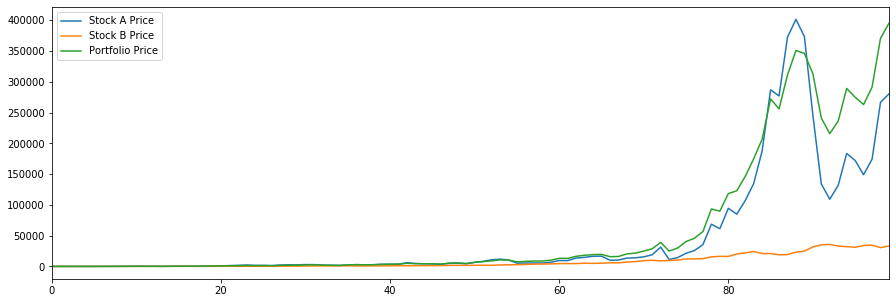

In [20]:
df[['Stock A Price', 'Stock B Price', 'Portfolio Price']].plot.line(figsize=(15, 5))

Now calculate mean and standard deviation for the stocks and the portfolio. We can do this with one command `describe`, or with the individual commands `mean` and `std`.

In [21]:
df.describe()

,Stock A Return,Stock B Return,Stock A Price,Stock B Price,Portfolio Return,Portfolio Price
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.124952,0.064257,47803.819996,7820.077349,0.100674,60300.101968
std,0.295467,0.097519,92133.565797,10751.109317,0.175442,107226.774166
min,-0.639157,-0.156848,131.823651,87.362009,-0.358483,121.779567
25%,-0.071907,0.001559,1847.585810,441.737979,-0.021360,1425.133483
50%,0.089173,0.062851,5548.012599,1934.725926,0.107022,6287.953427
75%,0.304945,0.130139,22519.703093,10946.062714,0.219236,39455.027873
max,0.928195,0.275294,401504.054259,35801.939670,0.642829,395225.334794


In [22]:
df.mean()

Stock A Return          0.124952
Stock B Return          0.064257
Stock A Price       47803.819996
Stock B Price        7820.077349
Portfolio Return        0.100674
Portfolio Price     60300.101968
dtype: float64

In [23]:
df.std()

Stock A Return           0.295467
Stock B Return           0.097519
Stock A Price        92133.565797
Stock B Price        10751.109317
Portfolio Return         0.175442
Portfolio Price     107226.774166
dtype: float64